# Measuring Volatility: The ARCH Model

* Volatility 
  * Numeric measurement of uncertainty 
  * e.g. securities, market indices, etc. 
  * Often not directly observable 
  * It evolves continously 
  * Doesn't go off to infinity 
  * Investors prefer stability. ARCH will help to chose one with lower volatility 

* ARCH: Autoregressive Conditional Heteroscedasticity model 
  * Heteroscedasticity = "different dispersion" -> variance 
  * Conditional = "A value that depends on others" -> $(\sigma^2_t|\sigma^2_{1}, \sigma^2_{2}, ..., \sigma^2_{t-1})$
* ARCH model 
  * $\text{Var}(y_t|y_{t-1}) = \sigma_t^2 = \alpha_0 + \alpha_1 \epsilon^2_{t-1}$
  * $r_t = \mu_t + \epsilon_t$
    * whether the mean comes from a ARMAX model or is a constant depends on the dataset
    * We often assume mean is serially uncorrelated and there is no time-dependent pattern 
    * When time-dependent, we can adopt an ARMA - ARCH model by using ARMA to model the variable and leave the ARCH component to deal with the variance caused by unexpected shocks 
* Simple ARCH 
  * 3-equation 
    * $r_t = \mu_t + \epsilon_t$
    * $\mu_t = C_0 + \varphi_1 \mu_{t-1}$
    * $\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon^2_{t-1}$
  * 2-equation
    * $r_t = C_0 + \varphi_1 \mu_{t-1} + \epsilon_t$
    * $\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon^2_{t-1}$
* Higher-order ARCH(q) 
  * $\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon^2_{t-1} + \alpha_2 \epsilon^2_{t-2} + ... + \alpha_q \epsilon^2_{t-q}$
* How to find the number of lags to include 
  * PACF of $y_t$ & $y_t^2$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2
from math import sqrt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_csv_data = pd.read_csv('../data/Index2018.csv')
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.set_index("date", inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value'] = df_comp.ftse

In [4]:
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size].copy(), df_comp.iloc[size:].copy()

# Create Returns & Squared Returns

In [5]:
df['returns'] = df.market_value.pct_change(1) * 100
df['sq_returns'] = df['returns']**2

# Returns vs Squared Returns

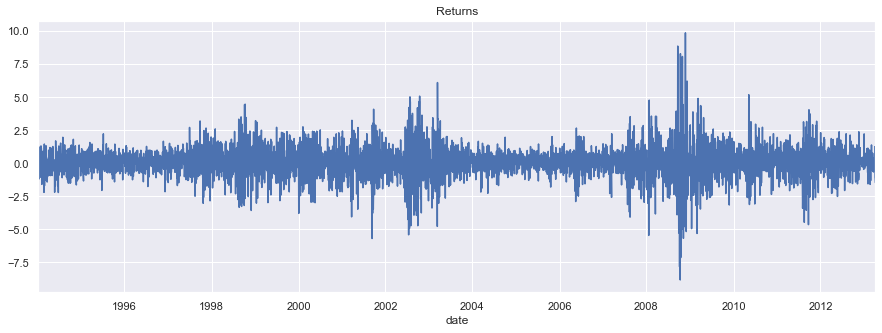

In [7]:
df.returns.plot(figsize=(15, 5))
plt.title("Returns")
plt.show()

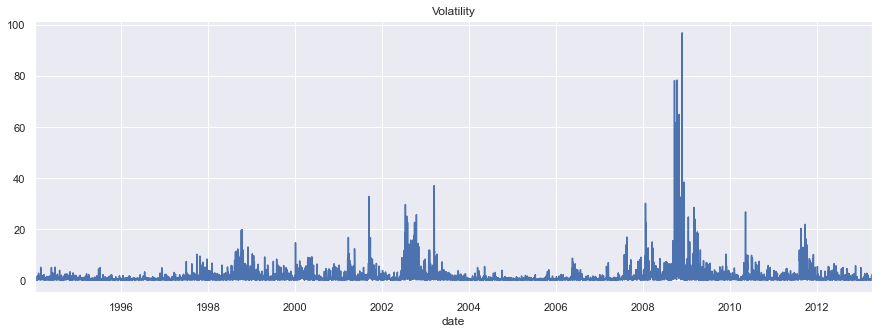

In [8]:
df.sq_returns.plot(figsize=(15, 5))
plt.title("Volatility")
plt.show()

The smaller variance and higher variance in the Returns data are represented in Volatility.

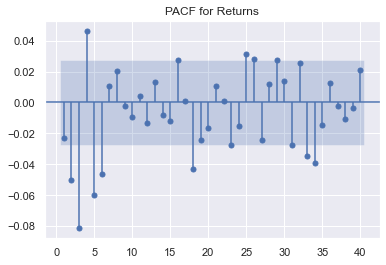

In [9]:
sgt.plot_pacf(df.returns[1:], lags=40, alpha=0.05, zero=False, method='ols')
plt.title("PACF for Returns")
plt.show()

The rule of thumb is that when a time-series resembles white noise, squared version suggests using an AR(N) model, we should resort to using an ARCH(n) to model variance. However, the PACF plot for Returns were the first several lags were significant. Therefore, we can't directly use the rule of thumb. 

Regardless, we should still have a look at the squared values to get an idea about which lags are significant so we gain insights on how the data performs.

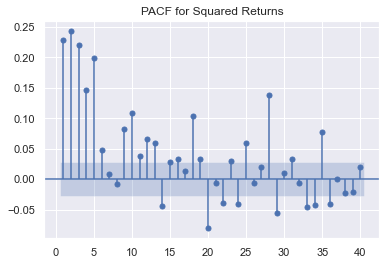

In [10]:
sgt.plot_pacf(df.sq_returns[1:], lags=40, alpha=0.05, zero=False, method='ols')
plt.title("PACF for Squared Returns")
plt.show()

The fact that the first five lags are significant in PACF suggests that there tend to be short-term trends in variance. Another way to think about this is variance clustering; we have periods of high variation followed by periods of high variations, as well as periods of low variation followed by periods of low variation. 

# The arch_model() Method

In [12]:
from arch import arch_model

In [13]:
model_arch_1 = arch_model(df.returns[1:])
results_arch_1 = model_arch_1.fit()
results_arch_1.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 10655466386.949347
Iteration:      2,   Func. Count:     15,   Neg. LLF: 952793978.0630096
Iteration:      3,   Func. Count:     23,   Neg. LLF: 7009.028860263045
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7024.036751000337
Iteration:      5,   Func. Count:     35,   Neg. LLF: 7010.712762828675
Iteration:      6,   Func. Count:     41,   Neg. LLF: 6975.418132248602
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7092.288792382339
Iteration:      8,   Func. Count:     53,   Neg. LLF: 6973.879345056244
Iteration:      9,   Func. Count:     59,   Neg. LLF: 6970.08804424179
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6970.05847839524
Iteration:     11,   Func. Count:     69,   Neg. LLF: 6970.058367475622
Iteration:     12,   Func. Count:     74,   Neg. LLF: 6970.058366189893
Iteration:     13,   Func. Count:     78,   Neg. LLF: 6970.058366189178
Optimization terminated successfully    (Exit mode 0)
           

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Sat, Feb 27 2021   Df Residuals:                     5019
Time:                        22:04:27   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

Mean is a single value. Since we saw this as a constant mean model we expect only a single constant coefficeint to be determined for this equation. Furthermore, the large t value suggests significance of the coefficient. So we know the mean isn't zero.  

The last part of the table is called the volatility model and it's what we're really interested in when we deal with ARCH. The omega represents the constant value in the variance ($\alpha_1$). THen there is the coefficient for the squared values. Right under it, we have beta[1]. 

For iteration, it took many iterations before it converges as we are fitting two equations at the same time. It fits a model with certain coefficients then checks how well it is performed. Afterwards, it adjusts the coefficients before making the secondary guess, and so on. 

# The Simple ARCH(1)

In [14]:
model_arch_1 = arch_model(df.returns[1:], mean="Constant", vol="ARCH", p=1)
results_arch_1 = model_arch_1.fit()
results_arch_1.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 29071.83486537579
Iteration:      2,   Func. Count:     13,   Neg. LLF: 12040.736044828116
Iteration:      3,   Func. Count:     20,   Neg. LLF: 7809.7227529035545
Iteration:      4,   Func. Count:     26,   Neg. LLF: 7660.088789376123
Iteration:      5,   Func. Count:     30,   Neg. LLF: 7660.088782040875
Iteration:      6,   Func. Count:     33,   Neg. LLF: 7660.088782040906
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7660.088782040875
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7660.09
Distribution:                  Normal   AIC:                           15326.2
Method:            Maximum Likelihood   BIC:                           15345.7
                                        No. Observations:                 5020
Date:                Sat, Feb 27 2021   Df Residuals:                     5019
Time:                        22:16:29   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0345  1.603e-02      2.151  3.147e-02 [3.063e-03,6.590e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9206  4.309e-02     21.365 2.855e-101 [  0.836,  1.005]
alpha[1]       0.3684  5.040e-02      7.310  2.673e-13 [  0.270,  0.467]
========================================================================

Covariance estimator: robust
"""